In [2]:
# IMPORT
from IPython.display import Image, Math

import os
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from utils import *
import numpy as np
import pandas as pd
import pyAgrum
import pyAgrum.skbn as skbn
import pyAgrum.lib.notebook as gnb
import pyAgrum.lib.image as gimg
import pyAgrum.lib.dynamicBN as gdyn
import pyAgrum.causal as pyc
import pyAgrum.causal.notebook as cslnb
import re

In [3]:
def format_evidence_for_latex(evidence):
    formatted_evidence = []
    
    for var in evidence.keys():
        # Replace the part after the underscore with curly braces, if applicable
        var = re.sub(r'_(\w+)', r'_{\1}', var)  # Add {} around the part after the underscore
        
        # Replace '0' with '_{t-1}'
        var = var.replace('t', '_t')
        var = var.replace('0', '_{t-1}')

        # Append formatted variable to the list
        formatted_evidence.append(f"${var}$")  # Adding $ for LaTeX format
        
    return ', '.join(formatted_evidence)

def plot_distributions(var, distributions, name):
    # Number of distributions to plot
    n = len(distributions)
    
    # Create subplots (one for each distribution)
    fig, axes = plt.subplots(n, 1, figsize=(12, 4 * n))  # n rows, 1 column

    # If there's only one plot, axes is not a list, so we handle it separately
    if n == 1:
        axes = [axes]

    for i, (data, title) in enumerate(distributions):
        # Plot the distribution in the corresponding subplot
        axes[i].bar(range(len(data)), data)
        var_str = format_evidence_for_latex({var: None})
        axes[i].set_xlabel(f"{var_str} States")
        axes[i].set_ylabel("Probability")
        axes[i].set_title(title)

    # Adjust layout to prevent overlap
    plt.tight_layout()

    # Save the figure with a dynamic filename (e.g., based on variable name and distributions)
    path = f"/home/lcastri/git/causalflow/results/my_pyAgrum/{var}/"
    filename = f"{name}.png"
    os.makedirs(os.path.dirname(path), exist_ok=True)
    plt.show()
    # plt.savefig(path+filename)
    # plt.close(fig)
    
def find_bin(value, edges):
    """
    Given a continuous value and an array of bin edges,
    return the index of the bin that contains the value.
    """
    idx = np.digitize(value, edges, right=False) - 1
    return int(max(0, min(idx, len(edges) - 2)))

In [4]:
# DATA
DAGDIR = '/home/lcastri/git/causalflow/results/BL100_21102024/res.pkl'
INDIR = '/home/lcastri/git/PeopleFlow/utilities_ws/src/RA-L/hrisim_postprocess/csv'
BAGNAME= ['noncausal-11022025']
variables = ['TOD', 'R_V', 'R_B', 'C_S', 'PD', 'ELT', 'L', 'EC', 'WP']
starting_t = 100
treatment_len = 100

for bagname in BAGNAME:
    for wp in WP:
        dfs = []
        if wp == WP.PARKING or wp == WP.CHARGING_STATION: continue
        for tod in TOD:
            if tod == TOD.OFF: continue
            files = [f for f in os.listdir(os.path.join(INDIR, "HH/my_nonoise", f"{bagname}", f"{tod.value}"))]
            files_split = [f.split('_') for f in files]
            wp_files = [f for f in files_split if len(f) == 3 and f[2].split('.')[0] == wp.value][0]
            wp_file = '_'.join(wp_files)
            print(f"Loading : {wp_file}")
            filename = os.path.join(INDIR, "HH/my_nonoise", f"{bagname}", f"{tod.value}", wp_file)

            df = pd.read_csv(filename)
            dfs.append(df)
        concat_df = pd.concat(dfs, ignore_index=True)
        break
    
D = concat_df.drop('pf_elapsed_time', axis=1)
D = D.drop('WP', axis=1)
D = D.drop('T', axis=1)
D = D.drop('R_X', axis=1)
D = D.drop('R_Y', axis=1)
D = D.drop('G_X', axis=1)
D = D.drop('G_Y', axis=1)
D = D.drop('NP', axis=1)
D = D.drop('C_S', axis=1)
# D = D.drop('EC', axis=1)
# D = D.rename(columns={'B_S': 'C_S'})
original_names = list(D.columns)
D.columns = [f'{v}t' for v in original_names if v != 'WP' and v != 'C_S']
# D.columns = [f'{v}t' for v in original_names if v != 'WP' and v != 'EC']

# Add lagged variable
for v in original_names:
    # if v != 'WP':
    # if v != 'WP' and v != 'EC':
    if v != 'WP' and v != 'C_S':
        D[f'{v}0'] = np.concatenate([D[f'{v}t'].values[1:], [0]])
D = D.iloc[1:].reset_index(drop=True)  # Remove first row
D = D.iloc[:-1].reset_index(drop=True)  # Remove last row

Loading : noncausal-11022025_H1_door-entrance.csv
Loading : noncausal-11022025_H2_door-entrance.csv
Loading : noncausal-11022025_H3_door-entrance.csv
Loading : noncausal-11022025_H4_door-entrance.csv
Loading : noncausal-11022025_H5_door-entrance.csv
Loading : noncausal-11022025_H6_door-entrance.csv
Loading : noncausal-11022025_H7_door-entrance.csv
Loading : noncausal-11022025_H8_door-entrance.csv
Loading : noncausal-11022025_H9_door-entrance.csv
Loading : noncausal-11022025_H10_door-entrance.csv


/tmp/ipykernel_2647305/3865720262.py:3: DeprecationWarning: 
** pyAgrum.skbn.BNDiscretizer is deprecated since pyAgrum>1.15.0. A pyAgrum.lib.Discretizer has been created.

  discretizer=skbn.BNDiscretizer(defaultDiscretizationMethod='uniform', discretizationThreshold=15, defaultNumberOfBins=50)
/tmp/ipykernel_2647305/3865720262.py:15: DeprecationWarning: 
  ** Discretizer.discretizedBN is deprecated since pyAgrum>1.15.0. Please use Discretizer.discretizeTemplate instead.
  
  template = discretizer.discretizedBN(D)



** audit **
- TODt : 
    + method : NoDiscretization
    + values : [0. 1. 2. 3. 4. 5. 6. 7. 8. 9.]
    + type : Discrete
- R_Vt : 
    + method : quantile
    + param : 5
    + type : Continuous
    + minInData : 4.512177156357211e-05
    + maxInData : 0.8833266467462408
- R_Bt : 
    + method : quantile
    + param : 50
    + type : Continuous
    + minInData : 23.205440521240234
    + maxInData : 99.62411499023438
- Lt : 
    + method : NoDiscretization
    + values : [0. 1.]
    + type : Discrete
- PDt : 
    + method : NoDiscretization
    + values : [0.         1.27323954 2.54647909 3.81971863]
    + type : Discrete
- ELTt : 
    + method : quantile
    + param : 50
    + type : Continuous
    + minInData : 17.74744545160651
    + maxInData : 99.39251291184718
- ECt : 
    + method : quantile
    + param : 5
    + type : Continuous
    + minInData : 0.0
    + maxInData : 0.1898634135212849
- TOD0 : 
    + method : NoDiscretization
    + values : [0. 1. 2. 3. 4. 5. 6. 7. 8. 9.]


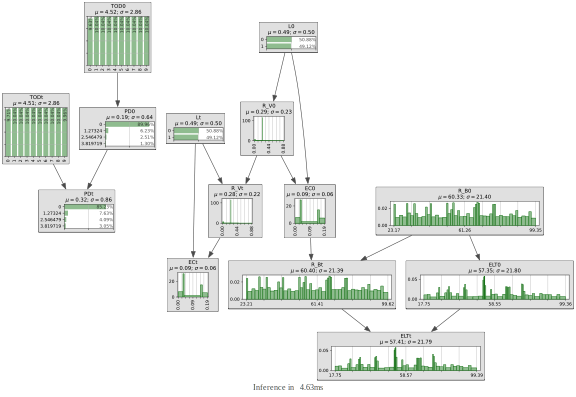

In [5]:
# DISCRETIZATION -- BN CREATION 

discretizer=skbn.BNDiscretizer(defaultDiscretizationMethod='uniform', discretizationThreshold=15, defaultNumberOfBins=50)
# discretizer.setDiscretizationParameters('PD0','quantile', 50)
# discretizer.setDiscretizationParameters('PDt','quantile', 50)
discretizer.setDiscretizationParameters('EC0','quantile', 5)
discretizer.setDiscretizationParameters('ECt','quantile', 5)
discretizer.setDiscretizationParameters('ELT0','quantile', 50)
discretizer.setDiscretizationParameters('ELTt','quantile', 50)
discretizer.setDiscretizationParameters('R_B0','quantile', 50)
discretizer.setDiscretizationParameters('R_Bt','quantile', 50)
discretizer.setDiscretizationParameters('R_V0','quantile', 5)
discretizer.setDiscretizationParameters('R_Vt','quantile', 5)

template = discretizer.discretizedBN(D)
auditDict=discretizer.audit(D)
print()
print("** audit **")
for var in auditDict:
    print(f"- {var} : ")
    for k,v in auditDict[var].items():
        print(f"    + {k} : {v}")
# template.addArc("WP0", "PD0")
template.addArc("TOD0", "PD0")
template.addArc("PD0", "PDt")
# template.addArc("WP0", "ELT0")
# template.addArc("EC0", "ELT0")
# template.addArc("L0", "R_B0")
template.addArc("R_B0", "ELT0")
# template.addArc("C_S0", "R_B0")
# template.addArc("C_S0", "R_V0")
template.addArc("L0", "EC0")
template.addArc("L0", "R_V0")
template.addArc("R_V0", "EC0")
# template.addArc("EC0", "R_B0")
# template.addArc("WPt", "PDt")
template.addArc("TODt", "PDt")
# template.addArc("WPt", "ELTt")
# template.addArc("Lt", "ELTt")
# template.addArc("Lt", "R_Bt")
template.addArc("R_Bt", "ELTt")
# template.addArc("C_St", "R_Bt")
# template.addArc("C_St", "R_Vt")
template.addArc("Lt", "R_Vt")
template.addArc("Lt", "ECt")
template.addArc("R_Vt", "ECt")
template.addArc("EC0", "R_Bt")
template.addArc("ELT0", "ELTt")
template.addArc("R_B0", "R_Bt")
# template.addArc("R_V0", "R_Bt")
template.addArc("R_V0", "R_Vt")
learner = pyAgrum.BNLearner(D, template)
learner.useEM(1e-8)
learner.useSmoothingPrior()
bn = learner.learnParameters(template)

time_slices_bn = gdyn.getTimeSlices(bn, size=20)

gnb.showInference(bn)

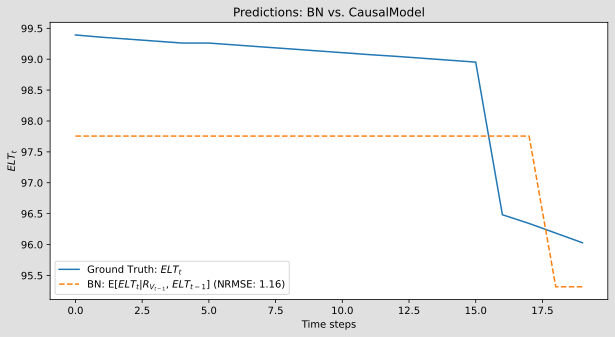

In [6]:
# For R_V0 (used as evidence)
quantiles_R_V0 = np.linspace(0, 100, auditDict['R_V0']['param'] + 1 if 'param' in auditDict['R_V0'] else auditDict['R_V0']['nbBins'] + 1)
edges_R_V0 = np.percentile(D['R_V0'].values, quantiles_R_V0)
# For ELT0 (used as evidence)
quantiles_ELT0 = np.linspace(0, 100, auditDict['ELT0']['param'] + 1 if 'param' in auditDict['ELT0'] else auditDict['ELT0']['nbBins'] + 1)
edges_ELT0 = np.percentile(D['ELT0'].values, quantiles_ELT0)
# For RBt (used as evidence)
quantiles_R_Bt = np.linspace(0, 100, auditDict['R_Bt']['param'] + 1 if 'param' in auditDict['R_Bt'] else auditDict['R_Bt']['nbBins'] + 1)
edges_R_Bt = np.percentile(D['R_Bt'].values, quantiles_R_Bt)

# For ELTt (used for expected value computation)
quantiles_ELTt = np.linspace(0, 100, auditDict['ELTt']['param'] + 1 if 'param' in auditDict['ELTt'] else auditDict['ELTt']['nbBins'] + 1)
edges_ELTt = np.percentile(D['ELTt'].values, quantiles_ELTt)
midpoints_ELTt = [(edges_ELTt[i] + edges_ELTt[i+1]) / 2.0 for i in range(len(edges_ELTt)-1)]

# ------------------------------
# Evaluate Predictions on a Test Set using BN inference and CausalModel (do-intervention)
# ------------------------------
n_test = 20
predicted_ELTt_bn = []      # Predictions using BN conditioning (setEvidence)
ground_truth_ELTt = []
target_var = "ELTt"
target_var_str = format_evidence_for_latex({target_var: None})
for i in range(n_test):
    # Use the continuous Bt value from the test instance
    RV_val = D.iloc[i]['R_V0']
    RV_bin_idx = find_bin(RV_val, edges_R_V0)
    ELT_val = D.iloc[i]['ELT0']
    ELT_bin_idx = find_bin(ELT_val, edges_ELT0)
    # RB_val = D.iloc[i]['R_Bt']
    # RB_bin_idx = find_bin(RB_val, edges_R_Bt)
    
    # --- BN prediction ---
    ie = pyAgrum.VariableElimination(bn)
    prior_ELTt = ie.posterior(target_var).toarray()
    evidence = {"R_V0": RV_bin_idx, "ELT0": ELT_bin_idx}
    # evidence = {"R_V0": RV_bin_idx, "ELT0": ELT_bin_idx, "C_S0": 0}
    evidence_str = format_evidence_for_latex(evidence)
    ie.setEvidence(evidence)
    ie.makeInference()
    bn_posterior = ie.posterior(target_var)
    bn_posterior_values = bn_posterior.toarray()
    # pred_bn = sum(bn_posterior_values[j] * midpoints_ELTt[j] for j in range(len(bn_posterior_values)))
    pred_bn = midpoints_ELTt[np.argmax(bn_posterior_values)]
    predicted_ELTt_bn.append(pred_bn)
    # plot_distributions(target_var, [(prior_ELTt, f"p({target_var_str})"), 
    #                                 (bn_posterior_values, f"p({target_var_str}|" + f"{evidence_str})")], 'BN_' + str(i))    
    # Ground-truth Dt value
    ground_truth_ELTt.append(D.iloc[i][target_var])

predicted_ELTt_bn = np.array(predicted_ELTt_bn)
ground_truth_ELTt = np.array(ground_truth_ELTt)

# ------------------------------
# Compare Predictions to Ground Truth
# ------------------------------
bn_RMSE = np.sqrt(np.mean((predicted_ELTt_bn - ground_truth_ELTt) ** 2))
bn_NRMSE = bn_RMSE/np.std(ground_truth_ELTt)

# ------------------------------
# Plot Predictions and Residuals
# ------------------------------
# Plot predicted vs. ground truth
plt.figure(figsize=(10, 5))
plt.plot(ground_truth_ELTt, label=f'Ground Truth: {target_var_str}', linestyle='-')
plt.plot(predicted_ELTt_bn, label=f'BN: E[{target_var_str}|{evidence_str}]' + f" (NRMSE: {bn_NRMSE:.2f})", linestyle='--')
plt.ylabel(f'{target_var_str}')
plt.xlabel(f'Time steps')
plt.title('Predictions: BN vs. CausalModel')
plt.legend()
plt.show()

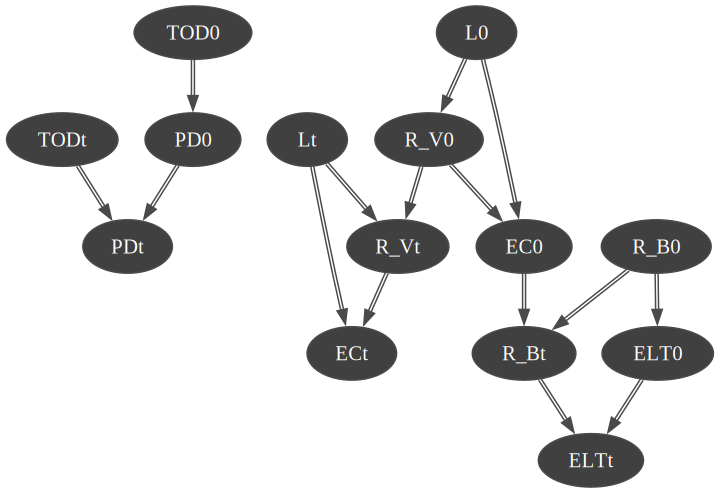

<IPython.core.display.Math object>

In [7]:
cm = pyc.CausalModel(bn)

# For R_V0 (used as evidence)
quantiles_R_V0 = np.linspace(0, 100, auditDict['R_V0']['param'] + 1 if 'param' in auditDict['R_V0'] else auditDict['R_V0']['nbBins'] + 1)
edges_R_V0 = np.percentile(D['R_V0'].values, quantiles_R_V0)
# For ELT0 (used as evidence)
quantiles_ELT0 = np.linspace(0, 100, auditDict['ELT0']['param'] + 1 if 'param' in auditDict['ELT0'] else auditDict['ELT0']['nbBins'] + 1)
edges_ELT0 = np.percentile(D['ELT0'].values, quantiles_ELT0)
# For RBt (used as evidence)
# quantiles_R_Bt = np.linspace(0, 100, auditDict['R_Bt']['param'] + 1 if 'param' in auditDict['R_Bt'] else auditDict['R_Bt']['nbBins'] + 1)
# edges_R_Bt = np.percentile(D['R_Bt'].values, quantiles_R_Bt)

# For ELTt (used for expected value computation)
quantiles_ELTt = np.linspace(0, 100, auditDict['ELTt']['param'] + 1 if 'param' in auditDict['ELTt'] else auditDict['ELTt']['nbBins'] + 1)
edges_ELTt = np.percentile(D['ELTt'].values, quantiles_ELTt)
midpoints_ELTt = [(edges_ELTt[i] + edges_ELTt[i+1]) / 2.0 for i in range(len(edges_ELTt)-1)]

# ------------------------------
# Evaluate Predictions on a Test Set using BN inference and CausalModel (do-intervention)
# ------------------------------
n_test = 20
RV_val = D.iloc[0]['R_V0']
RV_bin_idx = find_bin(RV_val, edges_R_V0)
ELT_val = D.iloc[0]['ELT0']
ELT_bin_idx = find_bin(ELT_val, edges_ELT0)
cslnb.showCausalModel(cm, size="10!")
a = pyc.doCalculusWithObservation(cm,"ELTt", {"R_V0"})
display(Math(a.toLatex()))




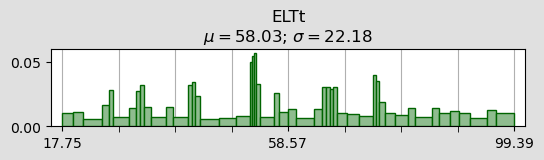


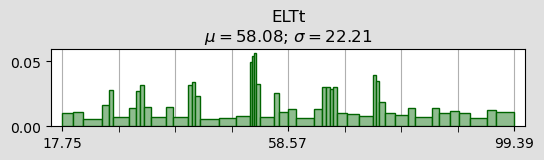


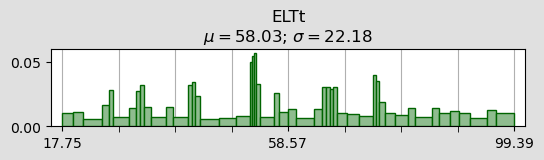


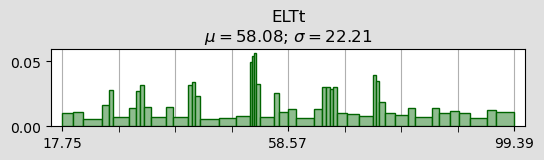


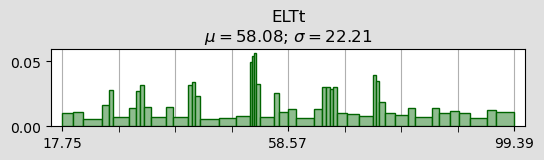

In [ ]:

# For R_V0 (used as evidence)
quantiles_R_V0 = np.linspace(0, 100, auditDict['R_V0']['param'] + 1 if 'param' in auditDict['R_V0'] else auditDict['R_V0']['nbBins'] + 1)
edges_R_V0 = np.percentile(D['R_V0'].values, quantiles_R_V0)
# For ELT0 (used as evidence)
quantiles_ELT0 = np.linspace(0, 100, auditDict['ELT0']['param'] + 1 if 'param' in auditDict['ELT0'] else auditDict['ELT0']['nbBins'] + 1)
edges_ELT0 = np.percentile(D['ELT0'].values, quantiles_ELT0)
# For RBt (used as evidence)
# quantiles_R_Bt = np.linspace(0, 100, auditDict['R_Bt']['param'] + 1 if 'param' in auditDict['R_Bt'] else auditDict['R_Bt']['nbBins'] + 1)
# edges_R_Bt = np.percentile(D['R_Bt'].values, quantiles_R_Bt)

# For ELTt (used for expected value computation)
quantiles_ELTt = np.linspace(0, 100, auditDict['ELTt']['param'] + 1 if 'param' in auditDict['ELTt'] else auditDict['ELTt']['nbBins'] + 1)
edges_ELTt = np.percentile(D['ELTt'].values, quantiles_ELTt)
midpoints_ELTt = [(edges_ELTt[i] + edges_ELTt[i+1]) / 2.0 for i in range(len(edges_ELTt)-1)]

# ------------------------------
# Evaluate Predictions on a Test Set using BN inference and CausalModel (do-intervention)
# ------------------------------
n_test = 20
predicted_ELTt_causal = []  # Predictions using CausalModel (do-intervention)
ground_truth_ELTt = []
target_var = "ELTt"
target_var_str = format_evidence_for_latex({target_var: None})
for i in range(n_test):
    # Use the continuous Bt value from the test instance
    RV_val = D.iloc[i]['R_V0']
    RV_bin_idx = find_bin(RV_val, edges_R_V0)
    ELT_val = D.iloc[i]['ELT0']
    ELT_bin_idx = find_bin(ELT_val, edges_ELT0)
    # RB_val = D.iloc[i]['R_Bt']
    # RB_bin_idx = find_bin(RB_val, edges_R_Bt)
    
    # --- BN prediction ---
    ie = pyAgrum.VariableElimination(bn)
    prior_ELTt = ie.posterior(target_var).toarray()  # prior marginal, as a NumPy array
    
    # --- CausalModel prediction ---
    # formula, adj, exp = pyc.causalImpact(cm, on="ELTt", doing="R_V0", values={"R_V0":RV_bin_idx})
    cslnb.showCausalImpact(cm, on="ELTt", doing="R_V0", knowing={"ELT0"}, values={"R_V0":RV_bin_idx, "ELT0":ELT_bin_idx})
    # cslnb.showCausalImpact(cm, on="ELTt", doing="R_V0", knowing={"ELT0", "C_S0"}, values={"R_V0":RV_bin_idx, "ELT0":ELT_bin_idx, "C_S0": 0})
    formula, adj, exp = pyc.causalImpact(cm, on="ELTt", doing="R_V0", knowing={"ELT0"}, values={"R_V0":RV_bin_idx, "ELT0":ELT_bin_idx})
    formula.toLatex()
    # formula, adj, exp = pyc.causalImpact(cm, on="ELTt", doing="R_V0", knowing={"ELT0", "C_S0"}, values={"R_V0":RV_bin_idx, "ELT0":ELT_bin_idx, "C_S0": 0})
    posterior_causal = adj.toarray()
    # pred_causal = sum(posterior_causal[j] * midpoints_ELTt[j] for j in range(len(posterior_causal)))
    pred_causal = midpoints_ELTt[np.argmax(posterior_causal)]
    predicted_ELTt_causal.append(pred_causal)
    # plot_distributions(target_var, [(prior_ELTt, f"p({target_var_str})"), 
    #                                 (posterior_causal, f"p({target_var_str}|" + f"{evidence_str})")], 'CM_' + str(i))
    
    # Ground-truth Dt value
    ground_truth_ELTt.append(D.iloc[i][target_var])

predicted_ELTt_causal = np.array(predicted_ELTt_causal)
ground_truth_ELTt = np.array(ground_truth_ELTt)

# ------------------------------
# Compare Predictions to Ground Truth
# ------------------------------
cm_RMSE = np.sqrt(np.mean((predicted_ELTt_causal - ground_truth_ELTt) ** 2))
cm_NRMSE = cm_RMSE/np.std(ground_truth_ELTt)

# ------------------------------
# Plot Predictions and Residuals
# ------------------------------
# Plot predicted vs. ground truth
plt.figure(figsize=(10, 5))
plt.plot(ground_truth_ELTt, label=f'Ground Truth: {target_var_str}', linestyle='-')
plt.plot(predicted_ELTt_causal, label=r'CM: $E[ELT_{t}|do(R_{V_{t-1}}), ELT_{t-1}]$' + f" (NRMSE: {cm_NRMSE:.2f})", linestyle=':')
plt.ylabel(f'{target_var_str}')
plt.xlabel(f'Time steps')
plt.title('Predictions: BN vs. CausalModel')
plt.legend()
plt.show()

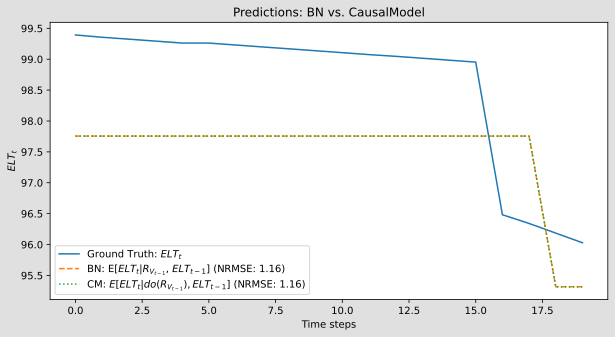

In [28]:
# ------------------------------
# Plot Predictions and Residuals
# ------------------------------
# Plot predicted vs. ground truth
plt.figure(figsize=(10, 5))
plt.plot(ground_truth_ELTt, label=f'Ground Truth: {target_var_str}', linestyle='-')
plt.plot(predicted_ELTt_bn, label=f'BN: E[{target_var_str}|{evidence_str}]' + f" (NRMSE: {bn_NRMSE:.2f})", linestyle='--')
plt.plot(predicted_ELTt_causal, label=r'CM: $E[ELT_{t}|do(R_{V_{t-1}}), ELT_{t-1}]$' + f" (NRMSE: {cm_NRMSE:.2f})", linestyle=':')
plt.ylabel(f'{target_var_str}')
plt.xlabel(f'Time steps')
plt.title('Predictions: BN vs. CausalModel')
plt.legend()
plt.show()